In [2]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
!unzip "/content/drive/MyDrive/CVC-ClinicDB.zip" #dataset in codingbasu@gmail.com

Archive:  /content/drive/MyDrive/CVC-ClinicDB.zip
   creating: CVC-ClinicDB/
   creating: CVC-ClinicDB/Original/
  inflating: CVC-ClinicDB/Original/504.tif  
  inflating: CVC-ClinicDB/Original/181.tif  
  inflating: CVC-ClinicDB/Original/500.tif  
  inflating: CVC-ClinicDB/Original/581.tif  
  inflating: CVC-ClinicDB/Original/109.tif  
  inflating: CVC-ClinicDB/Original/289.tif  
  inflating: CVC-ClinicDB/Original/415.tif  
  inflating: CVC-ClinicDB/Original/562.tif  
  inflating: CVC-ClinicDB/Original/214.tif  
  inflating: CVC-ClinicDB/Original/315.tif  
  inflating: CVC-ClinicDB/Original/309.tif  
  inflating: CVC-ClinicDB/Original/438.tif  
  inflating: CVC-ClinicDB/Original/221.tif  
  inflating: CVC-ClinicDB/Original/389.tif  
  inflating: CVC-ClinicDB/Original/587.tif  
  inflating: CVC-ClinicDB/Original/432.tif  
  inflating: CVC-ClinicDB/Original/560.tif  
  inflating: CVC-ClinicDB/Original/427.tif  
  inflating: CVC-ClinicDB/Original/84.tif  
  inflating: CVC-ClinicDB/Origina

In [12]:
IMAGE_SIZE = 256
EPOCHS = 30
BATCH = 8
LR = 1e-4
PATH = "/content/CVC-ClinicDB"

In [68]:
def load_data(path, split=0.1):
    images = sorted(glob(os.path.join(path, "Original/*")))
    masks = sorted(glob(os.path.join(path, "Ground Truth/*")))

    total_size = len(images)
    print(total_size)
    valid_size = int(split * total_size)
    test_size = int(split * total_size)


    train_x, valid_x = train_test_split(images, test_size=valid_size,random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size,random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=test_size,random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size,random_state=42)

    return (train_x,train_y),(valid_x,valid_y),(test_x,test_y)

In [69]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    x = np.expand_dims(x, axis=-1)
    return x

In [70]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1])
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset

In [71]:
(train_x,train_y),(valid_x,valid_y),(test_x,test_y)=load_data(PATH)
print('training_data:',len(train_x))
print('training_data:',len(valid_x))
print('training_data:',len(test_x))

612
training_data: 490
training_data: 61
training_data: 61


In [52]:
def read_and_rgb(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x

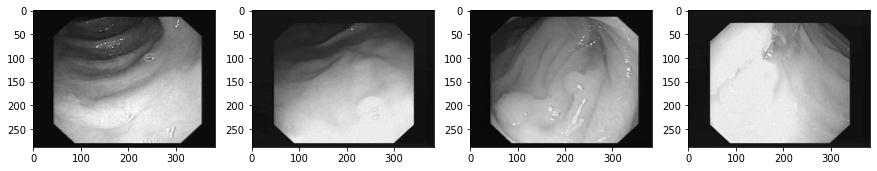

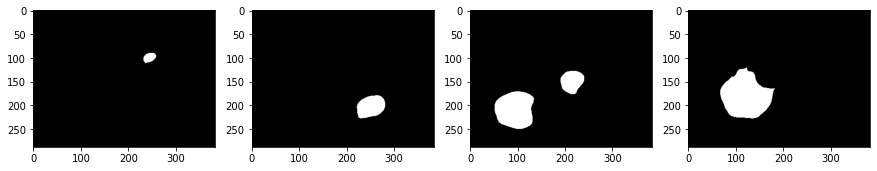

In [53]:
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_x[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_x[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_x[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_x[3]))
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_y[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_y[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_y[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_y[3]))
imgplot.set_clim(0.0, 1.4)

In [19]:
#link: https://idiotdeveloper.com/unet-segmentation-with-pretrained-mobilenetv2-as-encoder/
def model():
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    
    #encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)
    encoder = ResNet50(input_tensor=inputs, weights="imagenet", include_top=False)
    encoder.summary()
    skip_connection_names = ["input_image", "conv1_relu", "conv2_block3_out", "conv3_block4_out"]
    #encoder_output = encoder.get_layer("block_13_expand_relu").output
    encoder_output=encoder.get_layer('conv4_block6_2_relu').output
    f = [16, 32, 48, 64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        print(x_skip.shape)
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs, x)
    return model

In [72]:
def modelMobnet():
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    
    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)
    #encoder = ResNet50(input_tensor=inputs, weights="imagenet", include_top=False)
    encoder.summary()
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    #encoder_output = encoder.get_layer("block_13_expand_relu").output
    encoder_output=encoder.get_layer('block_13_expand_relu').output
    f = [16, 32, 48, 64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        print(x_skip.shape)
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs, x)
    return model

In [75]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [76]:
train_dataset = tf_dataset(train_x, train_y, batch=BATCH)
valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH)

In [77]:
#model-model()  for resnet50
model = modelMobnet()
opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

Model: "mobilenetv2_0.35_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 16  432         ['input_image[0][0]']            
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 16  64          ['Conv1[0][0]']                  
                                )                                              

In [78]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

In [79]:
train_steps = len(train_x)//BATCH
valid_steps = len(valid_x)//BATCH

if len(train_x) % BATCH != 0:
    train_steps += 1
if len(valid_x) % BATCH != 0:
    valid_steps += 1

In [80]:
model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/30
62/62 [==============================] - 35s 296ms/step - loss: 0.7462 - dice_coef: 0.2540 - recall_6: 0.6314 - precision_6: 0.2959 - val_loss: 0.7849 - val_dice_coef: 0.2109 - val_recall_6: 0.7287 - val_precision_6: 0.2557 - lr: 1.0000e-04
Epoch 2/30
62/62 [==============================] - 16s 258ms/step - loss: 0.6293 - dice_coef: 0.3699 - recall_6: 0.8337 - precision_6: 0.4732 - val_loss: 0.7898 - val_dice_coef: 0.2054 - val_recall_6: 0.4312 - val_precision_6: 0.4458 - lr: 1.0000e-04
Epoch 3/30
62/62 [==============================] - 16s 257ms/step - loss: 0.5772 - dice_coef: 0.4219 - recall_6: 0.8642 - precision_6: 0.5755 - val_loss: 0.7837 - val_dice_coef: 0.2107 - val_recall_6: 0.3235 - val_precision_6: 0.6740 - lr: 1.0000e-04
Epoch 4/30
62/62 [==============================] - 16s 258ms/step - loss: 0.5373 - dice_coef: 0.4616 - recall_6: 0.8835 - precision_6: 0.6527 - val_loss: 0.7799 - val_dice_coef: 0.2140 - val_recall_6: 0.2898 - val_precision_6: 0.7902 - lr: 1.0

In [81]:
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)

test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1

model.evaluate(test_dataset, steps=test_steps)

8/8 [==============================] - 1s 75ms/step - loss: 0.3576 - dice_coef: 0.6421 - recall_6: 0.6381 - precision_6: 0.7990


[0.35758161544799805,
 0.6420876383781433,
 0.6381286382675171,
 0.7989590167999268]

In [82]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    return x

In [83]:
def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

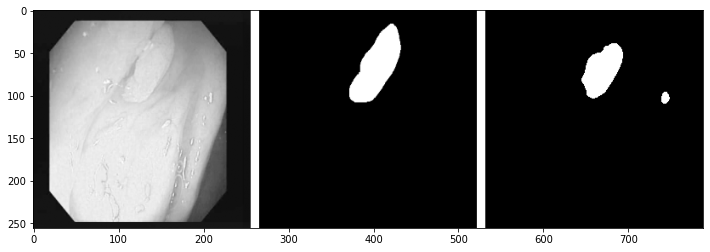

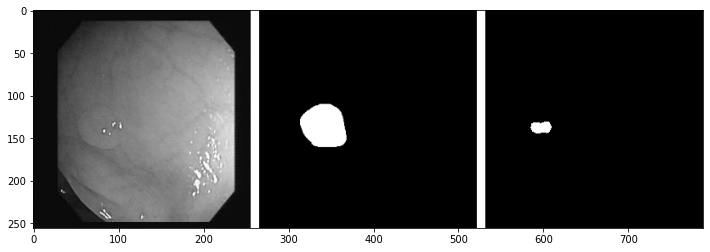

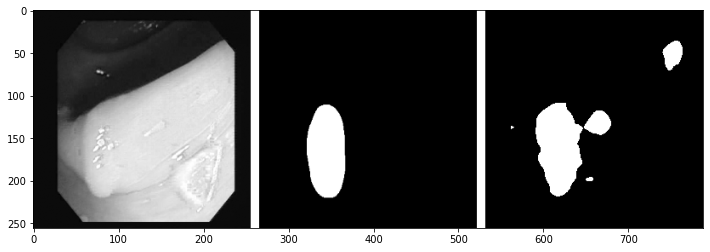

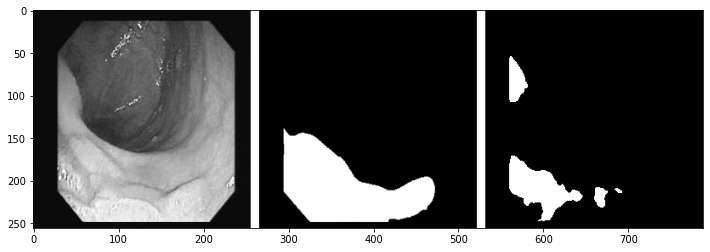

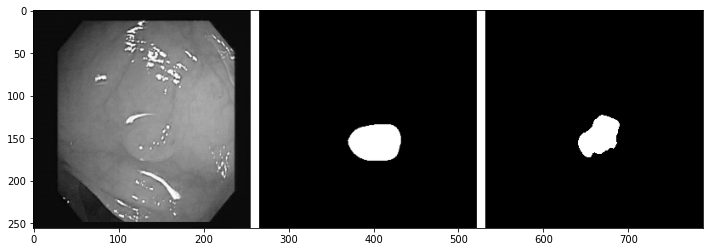

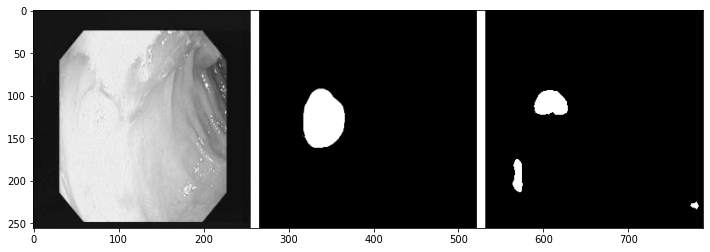

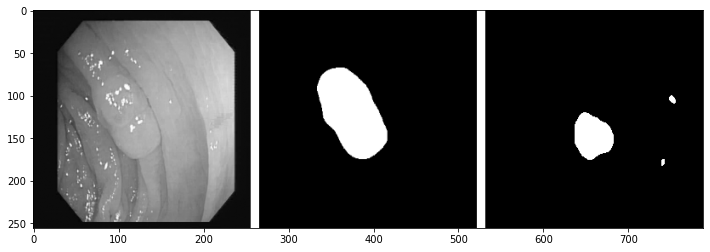

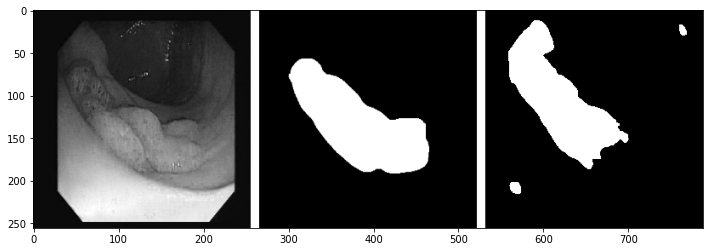

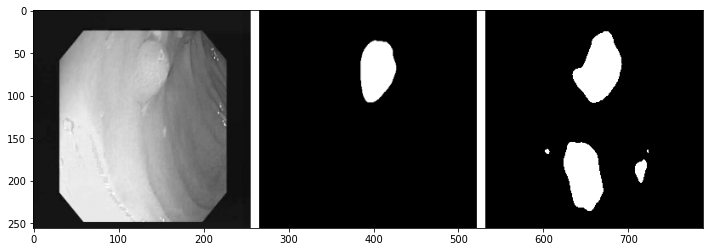

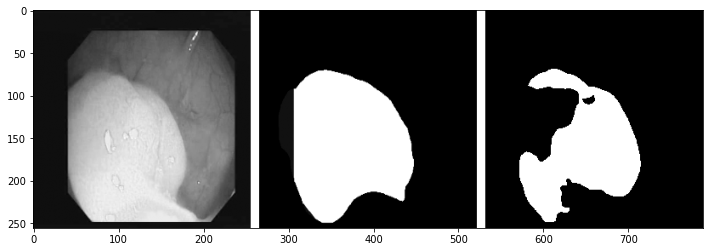

In [84]:
for i, (x, y) in enumerate(zip(test_x[:10], test_y[:10])):
    x = read_image(x)
    y = read_mask(y)
    y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
    h, w, _ = x.shape
    white_line = np.ones((h, 10, 3))

    all_images = [
        x, white_line,
        mask_parse(y), white_line,
        mask_parse(y_pred)
    ]
    image = np.concatenate(all_images, axis=1)
    
    fig = plt.figure(figsize=(12, 12))
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)

In [ ]:
# RESNET50 
#Epoch 30/30
#62/62 [==============================] - 31s 498ms/step - loss: 0.4145 - dice_coef: 0.5838 - recall: 0.9712 - precision: 0.9463 - val_loss: 0.4677 - val_dice_coef: 0.5279 - val_recall: 0.9057 - val_precision: 0.8671 - lr: 1.0000e-06
#[0.45482033491134644, 0.543467104434967, 0.8527770042419434, 0.8889532685279846]

#Mobilenetv2
#Epoch 30/30
#62/62 [==============================] - 16s 257ms/step - loss: 0.1381 - dice_coef: 0.8612 - recall_6: 0.9472 - precision_6: 0.9800 - val_loss: 0.3117 - val_dice_coef: 0.6854 - val_recall_6: 0.7125 - val_precision_6: 0.8274 - lr: 1.0000e-04
#[0.35758161544799805, 0.6420876383781433, 0.6381286382675171, 0.7989590167999268]